# Kriging Example 2¶

- Author: Mohit S. Chauhan 
- Date: Aug 20, 2018

In this example, Kriging is used to generate a surrogate model for a given data. In this data, sample points are generated using STS class and functional value at sample points are estimated using a model defined in python script ('python_model_function.py).

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the STS, RunModel and Krig class from UQpy.

In [1]:
from UQpy.surrogates import Kriging
from UQpy.surrogates.kriging.regression_models import Constant
from UQpy.surrogates.kriging.correlation_models import Exponential
from UQpy.utilities import Rectangular
from UQpy.sampling import StratifiedSampling
from UQpy.RunModel import RunModel
from UQpy.distributions import Uniform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

Create a distribution object. 

In [2]:
marginals = [Uniform(loc=0., scale=1.), Uniform(loc=0., scale=1.)]

Create a strata object.

In [3]:
strata = Rectangular(strata_number=[10, 10])

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [4]:
x = StratifiedSampling(distributions=marginals, strata_object=strata, samples_per_stratum_number=1, random_state=1)

RunModel is used to evaluate function values at sample points. Model is defined as a function in python file 'python_model_function.py'.

In [5]:
rmodel = RunModel(model_script='python_model_function.py', vec=False)
rmodel.run(samples=x.samples)

Using UQpy Krig class to generate a surrogate for generated data. In this illustration, Quadratic regression model and Exponential correlation model are used.

In [6]:
regression_model = Constant()
correlation_model = Exponential()
K = Kriging(regression_model=regression_model,
            correlation_model=correlation_model,
            optimizations_number=20,
            correlation_model_parameters=[1, 1])
K.fit(samples=x.samples, values=rmodel.qoi_list)
print(K.correlation_model_parameters)

[3.9925341  0.78877931]


This plot shows the actual model which is used to evaluate the samples to identify the function values.

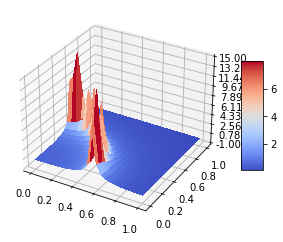

In [7]:
num = 25
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)

x1g, x2g = np.meshgrid(x1, x2)
x1gv, x2gv = x1g.reshape(x1g.size, 1), x2g.reshape(x2g.size, 1)

y2 = K.predict(np.concatenate([x1gv, x2gv], 1)).reshape(x1g.shape[0], x1g.shape[1])
r2model = RunModel(model_script='python_model_function.py')
r2model.run(samples=np.concatenate([x1gv, x2gv], 1))
y_act = np.array(r2model.qoi_list).reshape(x1g.shape[0], x1g.shape[1])

fig1 = plt.figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(x1g, x2g, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(-1, 15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

This plot shows the input data as red dot and green wirefram plot represent the kriging surrogate generated through Krig class.

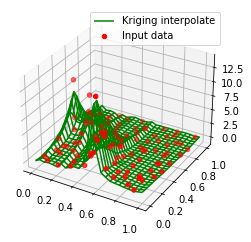

In [8]:
fig2 = plt.figure()
ax2 = plt.axes(projection='3d')
# Plot for estimated values
kr = ax2.plot_wireframe(x1g, x2g, y2, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax2.scatter3D(x.samples[:, 0], x.samples[:, 1], np.array(rmodel.qoi_list), color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()